# Detección de barras en galaxias - Análisis exploratorio de datos
## Proyecto integrador MNA

### Integrantes
- Jonathan Jesús Marmolejo Hernández - A01795195
- Isaid Posadas Oropeza - A01795015
- Luis Daniel Ortega Muñoz - A01795197

### Introducción

Este notebook contiene el análisis exploratorio de datos (EDA) del proyecto "Detección de barras en galaxias". El objetivo es explorar el conjunto de datos y entender mejor las características de las galaxias, así como la distribución de la variable objetivo.

### Importar librerías y cargar datos

Asumiendo que este notebook se encuentra en su directorio por defecto en el repositorio, el siguiente comando asegura que las utilerías creadas para este proyecto estén instaladas y sea posible importarlas:

In [1]:
!pip install https://github.com/ludanortmun/itesm-mna-barred-galaxies/archive/refs/heads/main.zip

     - 3.6 MB 11.7 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bargal: filename=bargal-0.1.0-py3-none-any.whl size=8215 sha256=2717e905caeecb2aa77abeb61aebc52cbad7400cd635745a905d7a0b34870761
  Stored in directory: /tmp/pip-ephem-wheel-cache-ky1v7l6j/wheels/44/42/ea/01aa01f7d487a80963df66723d5a54ec32246a42e0b5897a31
Successfully built bargal


In [2]:
!pip install ../.

ERROR: Directory '../.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

from bargal.images.client import GalaxyImageClient

In [8]:
#df = pd.read_csv("/content/itesm-mna-barred-galaxies-main/data/dataset.csv")

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Proyecto integrador/dataset.csv")


Mounted at /content/drive


### Estructura de los datos

En esta sección se describe la estructura general del conjunto de datos: número de registros y columnas, tipos de variables, valores faltantes y la distribución de clases en la variable `Bars`, que indica la presencia o ausencia de una barra en galaxias observadas.

Esta revisión inicial permite conocer la calidad de los datos y guiar decisiones para su limpieza y transformación en etapas posteriores.


In [9]:
# Vista general del dataset
df.head()


name       objra     objdec  Bars
0  manga-10001-12701  133.371091  57.598425   0.0
1  manga-10001-12702  133.685670  57.480250   0.5
2  manga-10001-12703  136.017160  57.092329   0.5
3  manga-10001-12704  133.989967  57.677968   0.0
4  manga-10001-12705  136.751375  57.451437   0.0

In [10]:
# Información sobre tipos de datos y valores no nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    10126 non-null  object 
 1   objra   10126 non-null  float64
 2   objdec  10126 non-null  float64
 3   Bars    10126 non-null  float64
dtypes: float64(3), object(1)
memory usage: 316.6+ KB


In [11]:
# Estadísticas de variables numéricas
df.describe()

objra        objdec          Bars
count  10126.000000  10126.000000  10126.000000
mean     183.138344     28.624910      0.248914
std       76.301840     17.968381      0.373190
min        0.008808     -9.302426     -0.500000
25%      128.891916     14.652696      0.000000
50%      194.107467     29.368107      0.000000
75%      239.689169     43.866542      0.500000
max      359.858576     65.289735      1.000000

In [12]:
# Distribución de clases en la variable Bars
df['Bars'].value_counts(dropna=False).sort_index()

Bars
-0.50      93
 0.00    6254
 0.25     436
 0.50    1542
 0.75     456
 1.00    1345
Name: count, dtype: int64

In [13]:
# Validación de que una misma galaxia no tenga clasificaciones distintas en Bars
duplicados = df.groupby('name')['Bars'].nunique()
inconsistentes = duplicados[duplicados > 1]

print("Galaxias con valores distintos de 'Bars' para el mismo 'name':")
print(inconsistentes)

print(f"\nTotal de galaxias con clasificaciones inconsistentes: {len(inconsistentes)}")


Galaxias con valores distintos de 'Bars' para el mismo 'name':
Series([], Name: Bars, dtype: int64)

Total de galaxias con clasificaciones inconsistentes: 0


Se realizó una validación de integridad para asegurar que cada galaxia (`name`) esté asociada a una única clasificación en la variable `Bars`.

El análisis no encontró inconsistencias, lo que indica que **no existen galaxias con más de una etiqueta diferente**, garantizando así la coherencia del dataset en esta dimensión.


### Análisis univariante

El análisis univariante permite estudiar cada variable del conjunto de datos de forma individual.  
Este enfoque facilita entender la distribución, comportamiento y valores atípicos de cada variable, lo cual es esencial para realizar un modelado adecuado más adelante.

En esta sección se analizan:
- Las variables numéricas `objra` (ascensión recta) y `objdec` (declinación) mediante histogramas, para observar su distribución.
- La variable categórica `Bars`, que representa la clasificación morfológica de las galaxias según el tipo de barra observada, a través de un gráfico de barras.

Cabe destacar que esta variable será transformada en la siguiente etapa (`has_bar`), pero aquí se presenta su distribución original.


Nuestro conjunto de datos se conforma de 4 columnas:
- `name`: nombre de la galaxia
- `objra`: coordenada RA (Ascención Recta)
- `objdec`: coordenada Dec (Declinación)
- `Bars`: Indica la presencia de una barra en la galaxia, asignando un nivel de claridad o confianza sobre dicha estructura. Los valores representan distintos grados de certeza en la identificación de una barra, siendo mayores los valores más seguros, y -0.5 indicando que no se evaluó o no se pudo determinar.

#### Histograma de objra

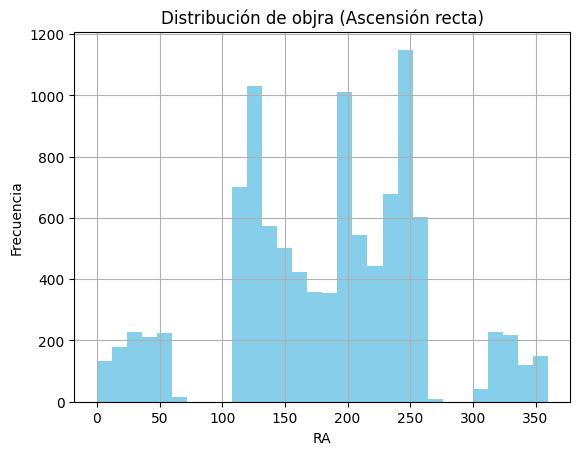

In [14]:
plt.hist(df['objra'], bins=30, color='skyblue')
plt.title('Distribución de objra (Ascensión recta)')
plt.xlabel('RA')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#### Histograma de objdec

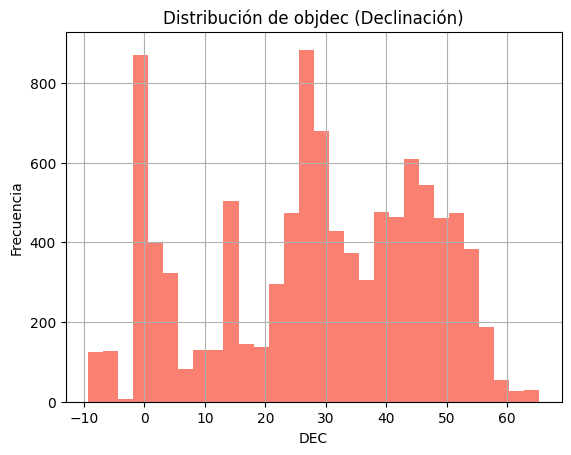

In [15]:
plt.hist(df['objdec'], bins=30, color='salmon')
plt.title('Distribución de objdec (Declinación)')
plt.xlabel('DEC')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


#### Gráfico de barras de Bars

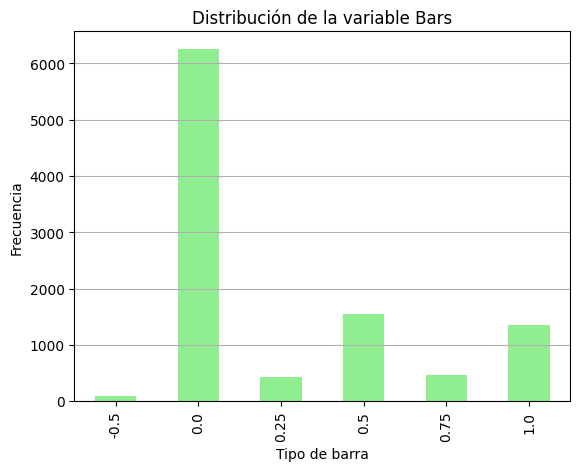

In [16]:
df['Bars'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Distribución de la variable Bars')
plt.xlabel('Tipo de barra')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()


#### Distribución de la clase objetivo

La variable objetivo es `Bars`, que representa la presencia de barras en las galaxias. Esta variable tiene 6 categorías:
- `-0.5`: Indeterminado
- `0`: Sin barra
- `0.25`: Barra débil
- `0.5`: Barra mezclada con los brazos de la galaxia
- `0.75`: Barra definida en el centro
- `1`: Barra definida y de gran tamaño relativo a la galaxia

Aunque la variable Bars representa categorías, es común graficar un boxplot de esta variable de forma informativa para visualizar su distribución general. Sin embargo, al tratarse de una variable categórica ordinal, el análisis más apropiado es cualitativo o mediante gráficos de barras que muestran la frecuencia de cada clase.

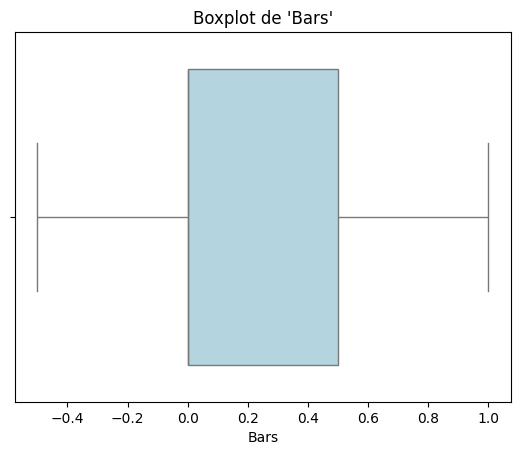

In [17]:
# Detección de valores atípicos

sns.boxplot(x=df['Bars'], color='lightblue')
plt.title("Boxplot de 'Bars'")
plt.show()

La distribución de la variable `Bars` muestra un desbalance importante entre las clases, con una mayor cantidad de galaxias clasificadas como sin barra o con barra débil, y muy pocas con barra fuerte.

Aunque esta variable presenta un problema de desbalance multiclase, en la siguiente etapa será transformada en una variable binaria (`has_bar`) que indicará simplemente si la galaxia tiene o no una barra. Esta transformación permitirá simplificar el problema y facilitar el modelado supervisado.

No obstante, visualizar la distribución original resulta útil para comprender el contexto de la clasificación y el tipo de datos disponibles en el catálogo.


###  Análisis bi/multivariante

A continuación, se exploran relaciones entre variables del conjunto de datos.  
Se utiliza un gráfico de dispersión para visualizar la distribución espacial de las galaxias según sus coordenadas astronómicas (`objra`, `objdec`) y su clasificación morfológica `Bars`, que indica el tipo o intensidad de barra galáctica.

Aunque esta variable será transformada posteriormente en una versión binaria (`has_bar`), en esta fase resulta útil para observar el contexto original de los datos.


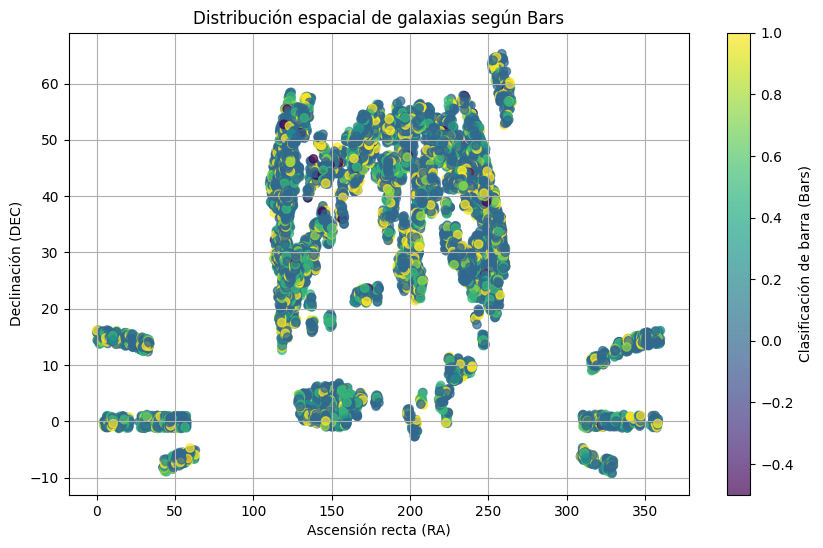

In [18]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['objra'], df['objdec'],
    c=df['Bars'], cmap='viridis', alpha=0.7
)
plt.colorbar(scatter, label='Clasificación de barra (Bars)')
plt.title('Distribución espacial de galaxias según Bars')
plt.xlabel('Ascensión recta (RA)')
plt.ylabel('Declinación (DEC)')
plt.grid(True)
plt.show()


El gráfico de dispersión muestra la distribución espacial de las galaxias en el cielo, con coordenadas `objra` (ascensión recta) y `objdec` (declinación). El color representa la clasificación de barra (`Bars`) asignada a cada galaxia.

Visualmente, no se observan agrupamientos evidentes entre el tipo de barra y la ubicación espacial, lo que implica que la presencia o intensidad de una barra no está directamente relacionada con la posición en el cielo. Sin embargo, esta visualización permite verificar la cobertura y uniformidad del muestreo astronómico, así como detectar posibles vacíos o concentraciones que puedan influir en el análisis posterior.

Cabe señalar que algunos puntos están clasificados como `-0.5`, lo que indica que no se pudo determinar su tipo de barra. Estos valores serán tratados más adelante en la etapa de preprocesamiento.


###  Preprocesamiento

La variable original `Bars` representa diferentes niveles de barra galáctica. Incluye valores como `0`, `0.5`, `1`, `2` y `-0.5`. Este último corresponde a galaxias no clasificadas.

Dado que el objetivo del proyecto es predecir si una galaxia **tiene o no tiene barra**, se transforma esta variable en una versión binaria llamada `has_bar`, de la siguiente forma:

- `1` si `Bars > 0` (la galaxia tiene algún tipo de barra)
- `0` si `Bars == 0` (la galaxia no tiene barra)
- `NaN` si `Bars == -0.5` (no se pudo clasificar)

Esta transformación permite mantener todas las observaciones del conjunto de datos, pero filtrar fácilmente las que sí tienen una clasificación válida para modelado supervisado. También se elimina la columna original `Bars` por ser redundante.


In [19]:
# Crear la columna binaria: 1 si tiene barra, 0 si no, NaN si no clasificada
df['has_bar'] = df['Bars'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else None))


#### Eliminación de la columna `Bars`

Una vez creada `has_bar`, la columna original `Bars` deja de ser necesaria.  
Se elimina para evitar redundancia y mantener el conjunto de datos más limpio y claro para las siguientes etapas.


In [20]:
# Eliminar la columna original 'Bars'
df.drop(columns=['Bars'], inplace=True)

Para verificar que la transformación a la variable `has_bar` se haya realizado correctamente, se grafica su distribución.  
Esto permite observar cuántas galaxias fueron clasificadas como barradas, no barradas o no clasificadas.

La variable presenta un desbalance moderado entre clases, pero es más manejable que en su versión original (`Bars`), lo cual facilitará el modelado binario.


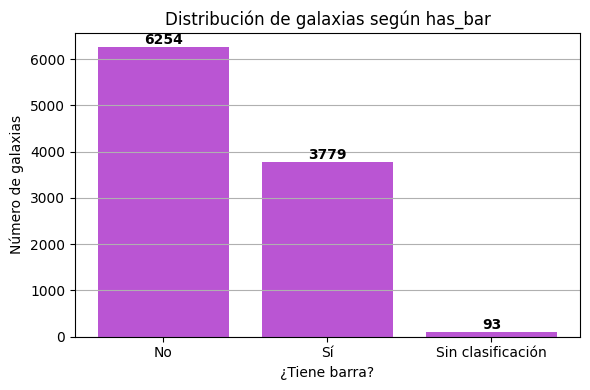

In [21]:
# Contar los valores (incluyendo NaN como categoría)
conteo = df['has_bar'].value_counts(dropna=False).sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
bars = plt.bar(
    x=["No", "Sí", "Sin clasificación"],
    height=conteo.values,
    color='mediumorchid'
)

# Agregar los valores encima de cada barra
for i, val in enumerate(conteo.values):
    plt.text(i, val + 2, str(val), ha='center', va='bottom', fontweight='bold')

# Títulos y ejes
plt.title('Distribución de galaxias según has_bar')
plt.xlabel('¿Tiene barra?')
plt.ylabel('Número de galaxias')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


####  Preparación del conjunto para modelado

Para el entrenamiento de modelos supervisados, se deben usar únicamente las observaciones con clasificación válida.  
Por ello, se crea un nuevo DataFrame que contiene solo las galaxias donde `has_bar` no es nulo.


In [22]:
# Crear subconjunto con galaxias clasificadas (has_bar no es NaN)
df_clasificadas = df[df['has_bar'].notna()].copy()


Una vez filtradas las galaxias con clasificación válida, se visualiza la distribución final de la variable `has_bar` en el subconjunto `df_clasificadas`.

Este gráfico representa el conjunto de datos que será utilizado para el modelado supervisado.  
Como se observa, aún existe cierto desbalance entre clases, aunque el problema es más manejable que en la versión original (`Bars`).


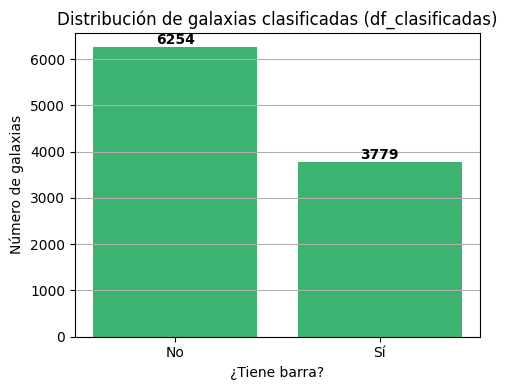

In [23]:
# Contar valores en el subconjunto filtrado (ya no hay NaN)
conteo_filtrado = df_clasificadas['has_bar'].value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(5, 4))
bars = plt.bar(
    x=["No", "Sí"],
    height=conteo_filtrado.values,
    color='mediumseagreen'
)

# Agregar etiquetas de conteo
for i, val in enumerate(conteo_filtrado.values):
    plt.text(i, val + 2, str(val), ha='center', va='bottom', fontweight='bold')

# Títulos y etiquetas
plt.title('Distribución de galaxias clasificadas (df_clasificadas)')
plt.xlabel('¿Tiene barra?')
plt.ylabel('Número de galaxias')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Visualización de galaxias

Como complemento al análisis, se presentan algunas imágenes reales de galaxias incluidas en el dataset, clasificadas según la presencia de barra.

Esta visualización ayuda a comprender cómo se ve una galaxia barrada frente a una no barrada, y a validar visualmente las etiquetas disponibles en el conjunto de datos.

La principal aplicación de este proyecto será la detección de barras en galaxias a partir de imágenes. Si bien el conjunto de datos no incluye de forma directa las imágenes, podemos obtenerlas a través de Legacy Survey, utilizando las coordenadas de la galaxia.

Como primer paso, obtenemos una muestra aleatoria de una galaxia en cada clase.

In [24]:
#df = pd.read_csv("../data/dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/Proyecto integrador/dataset.csv")
def get_random_galaxy(label=None):
    if label is None:
        return df.sample(1).to_dict(orient='records')[0]

    return df[df.Bars == label].sample(1).to_dict(orient='records')[0]


samples = {}

for l in df.Bars.unique():
    g = get_random_galaxy(l)
    samples[l] = g

Posteriormente, podemos utilizar la clase `GalaxyImageClient` para obtener las imágenes de las galaxias. Esta clase se encarga de descargar las imágenes y almacenarlas en un directorio local. En este caso, las imágenes se almacenarán en el directorio `../data/images`.

In [28]:
#img_client = GalaxyImageClient(storage_path="../data/images")
img_client = GalaxyImageClient(storage_path="/content/drive/MyDrive/Proyecto integrador/imagenes2")


In [29]:
imgs = {}

for g in samples.values():
    img = img_client.get_image(g, save_to_disk=True)
    imgs[g['name']] = img

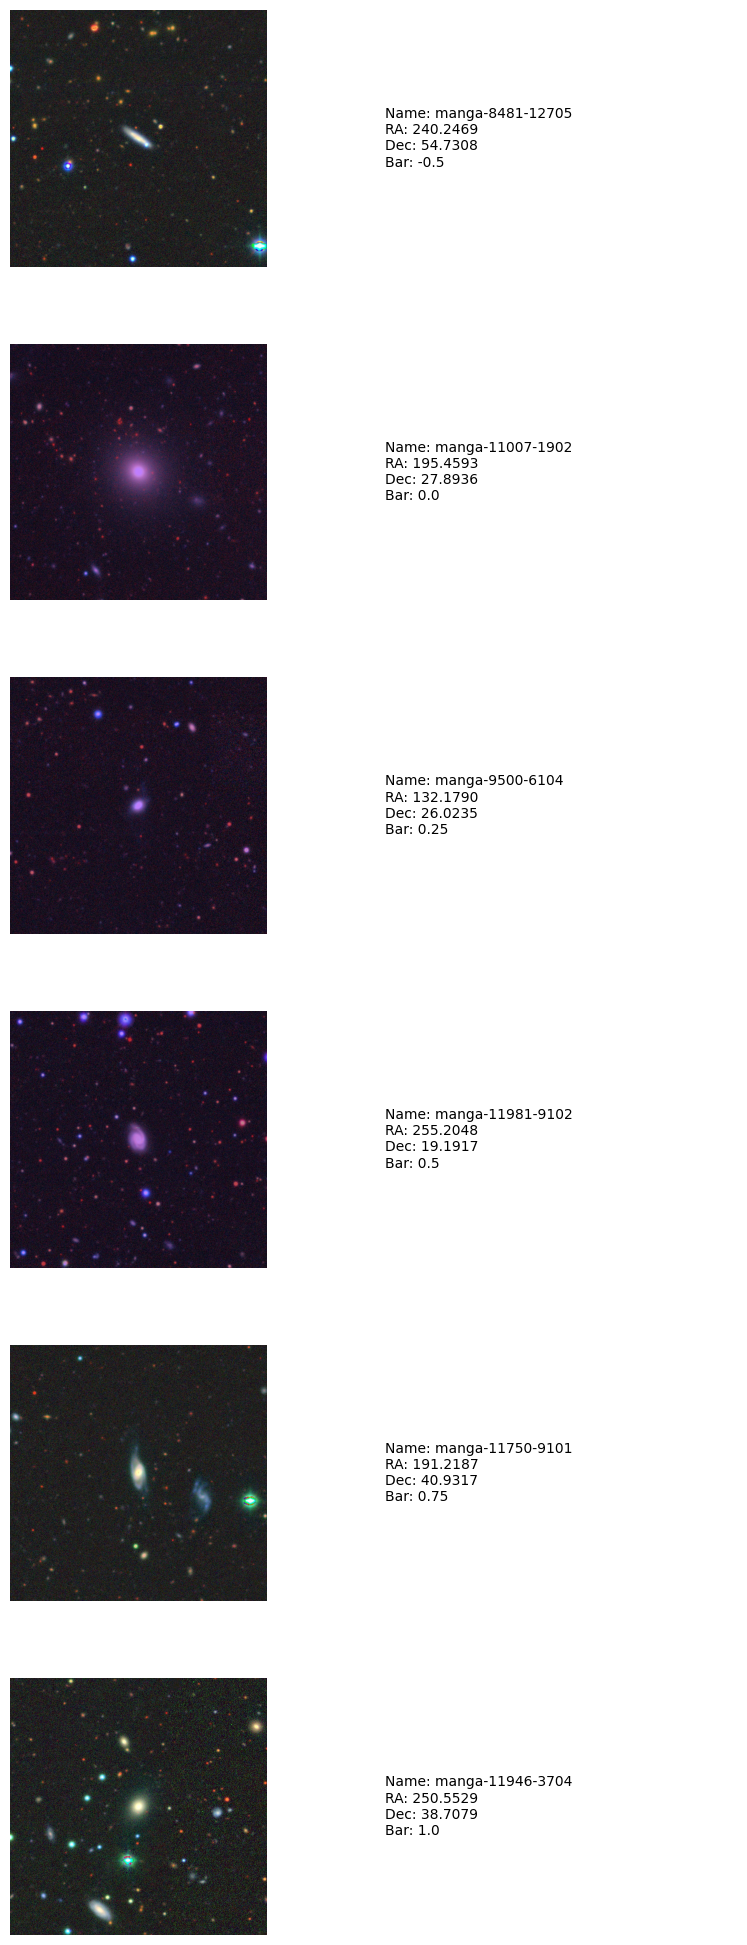

In [30]:
fig, axs = plt.subplots(6, 2, figsize=(10, 25))
plt.subplots_adjust(hspace=0.3)

for i, label in enumerate(sorted(samples.keys())):
    galaxy_data = samples[label]

    # Display image
    img_bytes = imgs[galaxy_data['name']]
    img = Image.open(BytesIO(img_bytes))
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')

    # Display properties
    props = f"Name: {galaxy_data['name']}\nRA: {galaxy_data['objra']:.4f}\nDec: {galaxy_data['objdec']:.4f}\nBar: {galaxy_data['Bars']}"
    axs[i, 1].text(0, 0.5, props, fontsize=10, va='center')
    axs[i, 1].axis('off')

plt.show()

#### Visualizando bandas individuales

Las imágenes mostradas anteriormente son una representación RGB de las bandas G, R y Z (luz verde, roja e infrarroja, respectivamente). Esta representación RGB es útil para una visualización que aproxima la percepción humana, pero también es posible realizar un análsis de las bandas individualmente. A continuación, se muestran las imágenes de cada banda por separado.

In [31]:
g = get_random_galaxy()

In [32]:
rgb_img = img_client.get_image(g, save_to_disk=True)
img_by_band = img_client.get_image_as_bands(g, bands='grz', save_to_disk=True)

imgs_to_render = [
    Image.open(BytesIO(rgb_img)),
    Image.open(BytesIO(img_by_band['g'])),
    Image.open(BytesIO(img_by_band['r'])),
    Image.open(BytesIO(img_by_band['z']))]

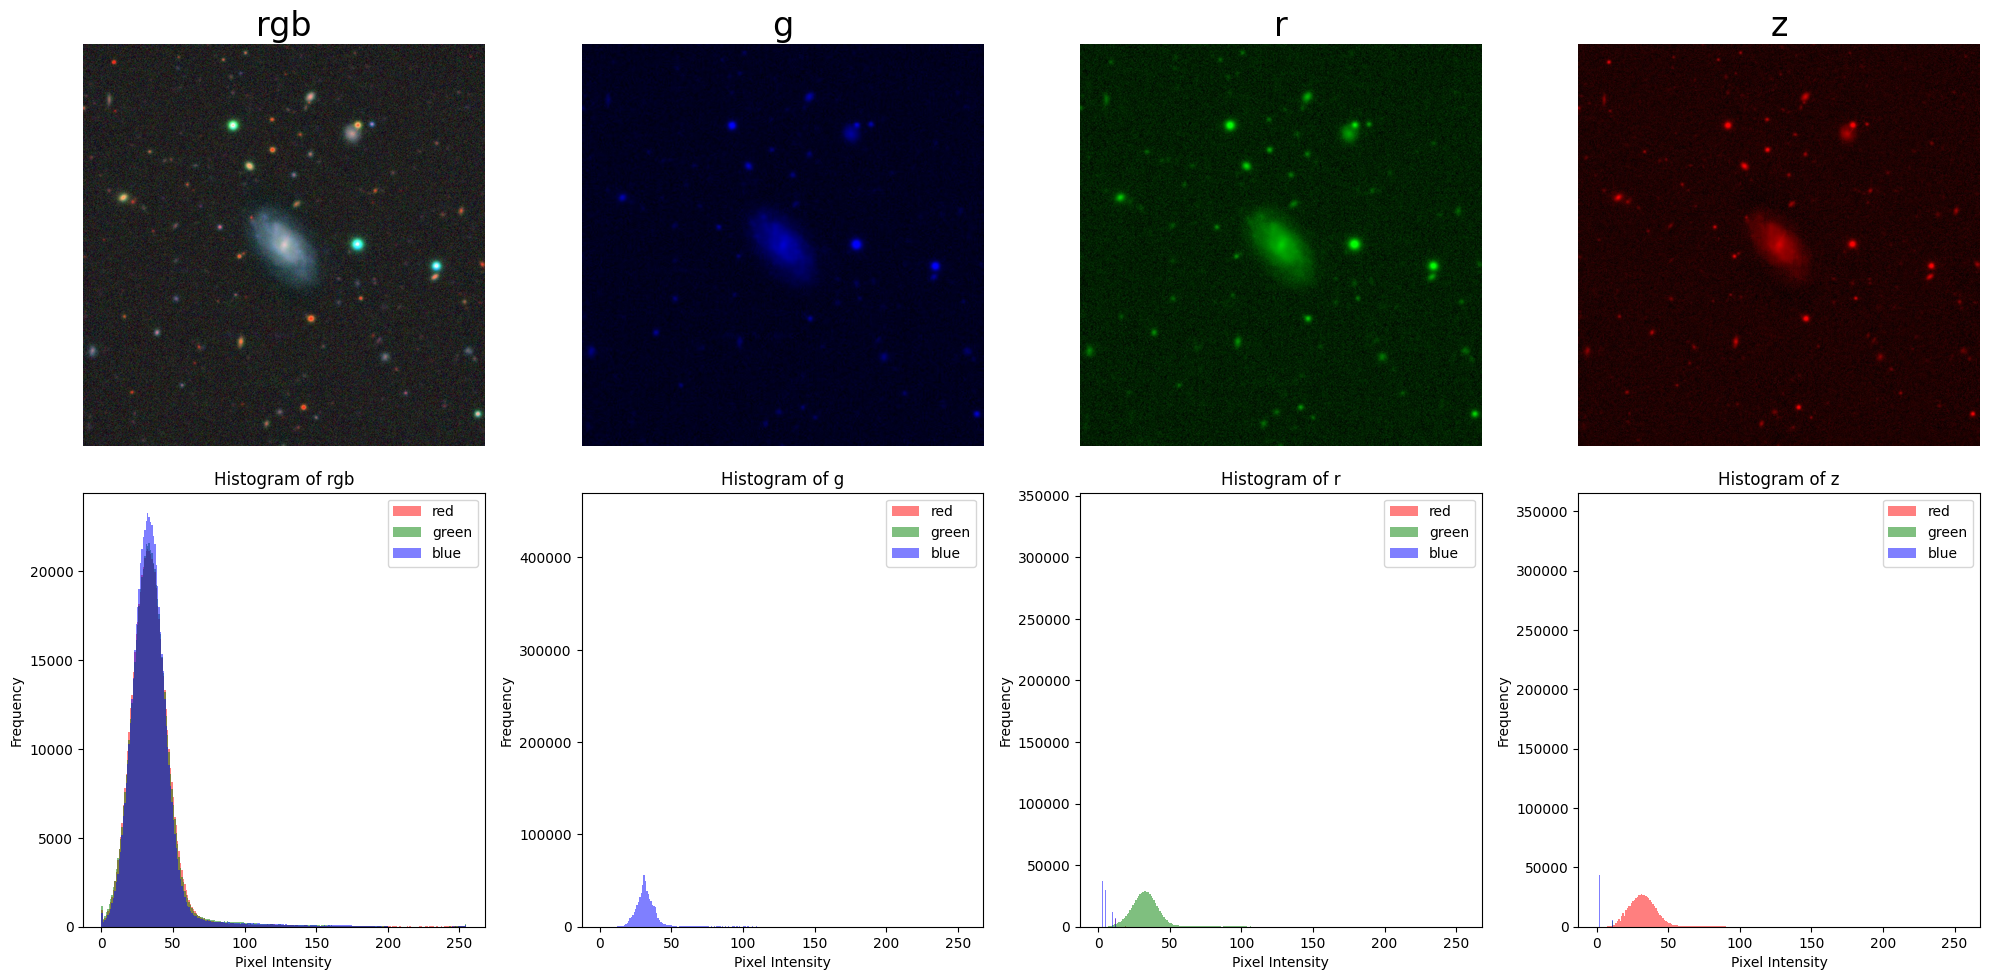

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

labels = ['rgb', 'g', 'r', 'z']  # Labels for each image

# Loop through the images and display them with histograms
for i, (img, label) in enumerate(zip(imgs_to_render, labels)):
    # Display the image
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(label, fontsize=24)

    # Display the histogram for each color channel
    img_array = np.array(img)
    colors = ['red', 'green', 'blue']
    for j, color in enumerate(colors):
        axs[1, i].hist(img_array[:, :, j].flatten(), bins=256, color=color, alpha=0.5, label=color)

    axs[1, i].set_title(f"Histogram of {label}", fontsize=12)
    axs[1, i].set_xlabel("Pixel Intensity")
    axs[1, i].set_ylabel("Frequency")
    axs[1, i].legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### Conclusiones del análisis exploratorio (EDA)

A partir del análisis exploratorio del conjunto de datos de galaxias, se pueden destacar las siguientes conclusiones clave:

Estructura y calidad de los datos:
- El conjunto de datos está bien estructurado, con variables numéricas (`objra`, `objdec`) y una variable categórica (`Bars`) que fue transformada correctamente.
- No se encontraron valores duplicados ni inconsistencias en la asignación de clasificaciones por galaxia (`name`).
- La variable `Bars` contiene un valor especial (`-0.5`) que indica falta de clasificación; fue tratada de forma adecuada sin eliminar observaciones útiles.

Análisis univariante:
- Las coordenadas astronómicas (`objra` y `objdec`) presentan una distribución amplia y dispersa.
- La variable `Bars` muestra un desbalance multiclase, con mayor cantidad de galaxias sin barra.
- Se creó una nueva variable binaria `has_bar`, que resume esta información y facilita el análisis.

Análisis multivariante:
- La visualización de las galaxias en función de su posición (RA vs DEC) y tipo de barra no muestra agrupamientos espaciales evidentes.
- La cobertura observacional parece uniforme y sin sesgos notables.

Preprocesamiento:
- Se transformó `Bars` en la variable binaria `has_bar`, con tres estados: barra (`1`), sin barra (`0`), y no clasificada (`NaN`).
- Se eliminó la columna original `Bars` para evitar redundancia.
- Se creó el subconjunto `df_clasificadas`, que incluye solo las galaxias con clasificación válida.

Preparación para el modelado:
- El conjunto `df_clasificadas` contiene las etiquetas (`has_bar`) asociadas a cada imagen mediante la columna `name`, lo que permite su uso directo en un modelo supervisado basado en imágenes.

En general, el conjunto de datos fue limpiado, estructurado y transformado correctamente. Ahora está preparado para ser utilizado como base en un enfoque de aprendizaje profundo, con el objetivo de construir un modelo que clasifique automáticamente si una galaxia tiene barra o no a partir de su imagen.


## SECCIÓN DE SEMANA 4 - Transformaciones para filtro de imagenes

In [34]:
# Librerías a utilizar en esta sección
import cv2
import os
from sklearn.decomposition import PCA

In [35]:
# Importar imagen y aplicación de filtro en gris
ruta = "/content/drive/MyDrive/Proyecto integrador/Imagenes2/6.JPG"
imagen_color = cv2.imread(ruta)
imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

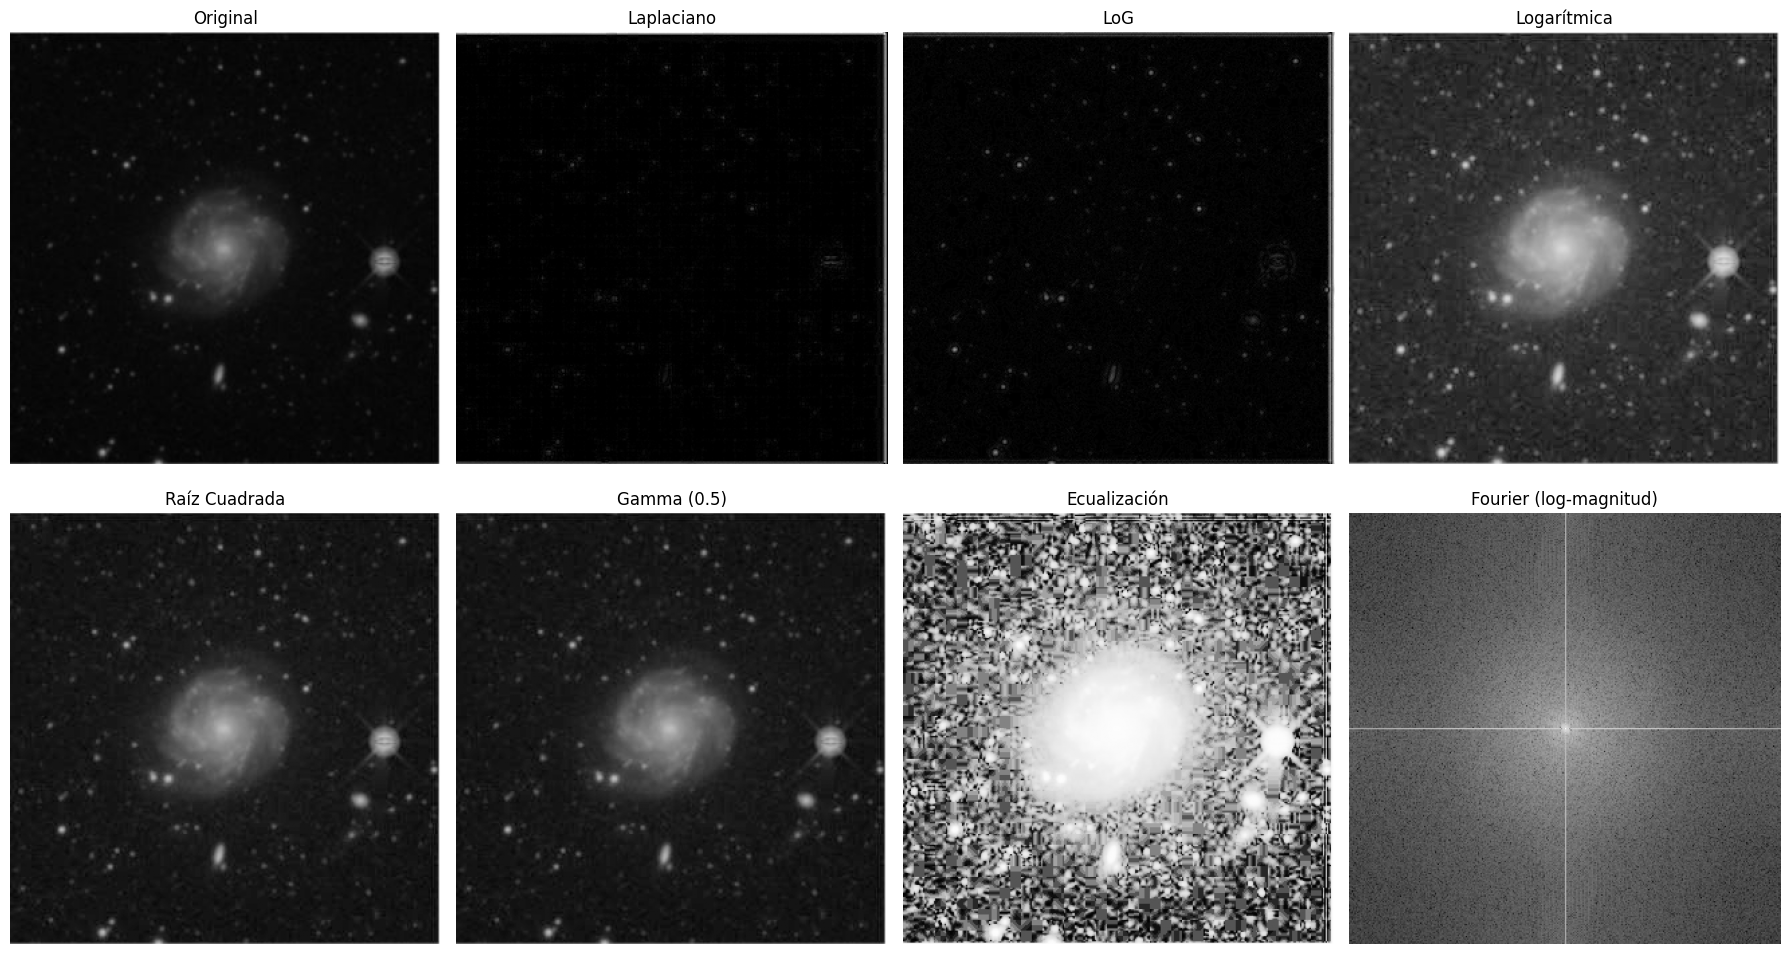

In [36]:
# Aplicación de transformaciones base sobre la imagen importada

def aplicar_transformaciones(img_gray):
    laplaciano = cv2.Laplacian(img_gray, cv2.CV_64F)
    gaussian = cv2.GaussianBlur(img_gray, (5, 5), 0)
    log = cv2.Laplacian(gaussian, cv2.CV_64F)
    log_transform = np.log1p(img_gray.astype(np.float32))
    sqrt_transform = np.sqrt(img_gray.astype(np.float32))
    gamma = np.power(img_gray / 255.0, 0.5) * 255.0
    hist_eq = cv2.equalizeHist(img_gray)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    fourier_mag = 20 * np.log1p(np.abs(fshift))

    return [
        ("Original", img_gray),
        ("Laplaciano", laplaciano),
        ("LoG", log),
        ("Logarítmica", log_transform),
        ("Raíz Cuadrada", sqrt_transform),
        ("Gamma (0.5)", gamma),
        ("Ecualización", hist_eq),
        ("Fourier (log-magnitud)", fourier_mag)
    ]

resultados = aplicar_transformaciones(imagen_gris)

plt.figure(figsize=(18, 10))
for i, (nombre, resultado) in enumerate(resultados):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.abs(resultado), cmap='gray')
    plt.title(nombre)
    plt.axis('off')
plt.tight_layout()
plt.show()

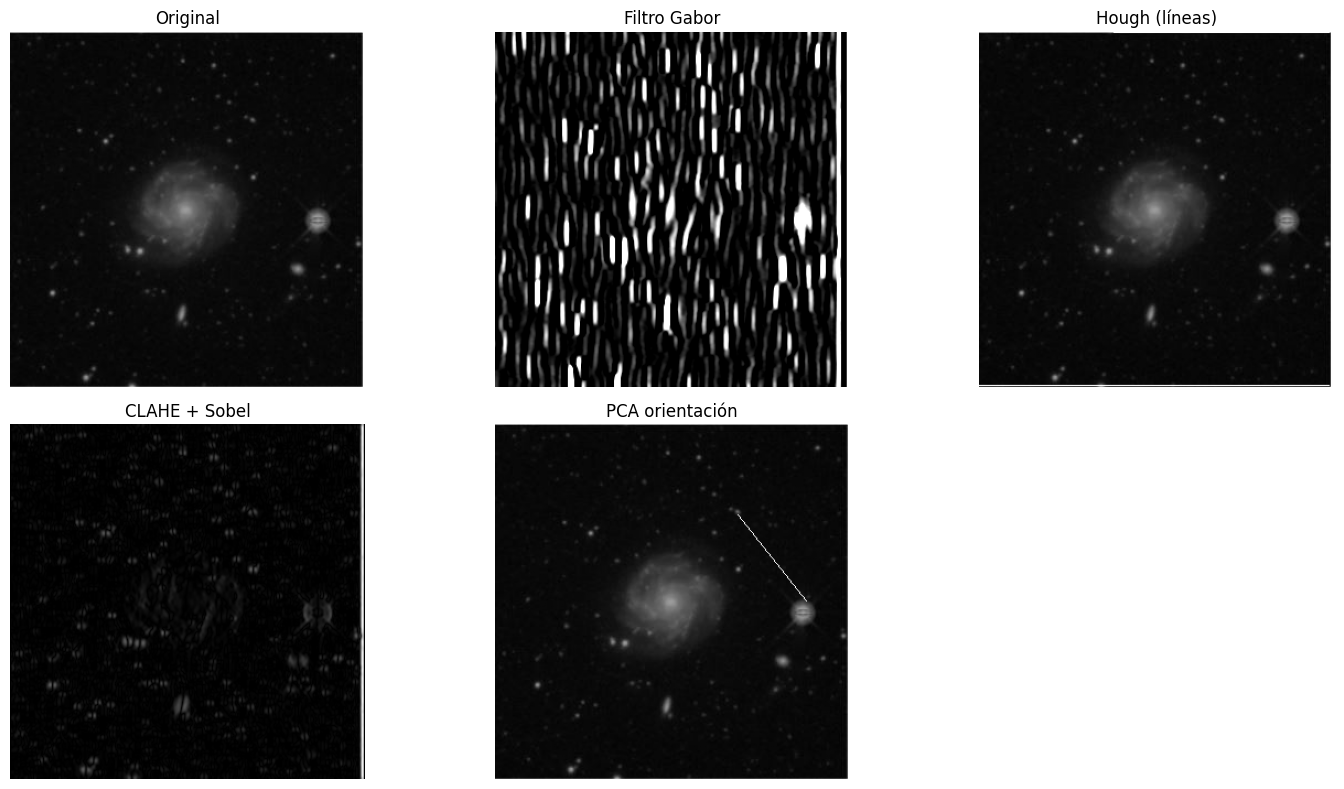

In [38]:
# Aplicación de 4 transformadas extra

def aplicar_transformaciones2(img_color):

    # Convertir a escala de grises
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    # 1. Filtro de Gabor (orientación 0 radianes)
    gabor_kernel = cv2.getGaborKernel((21, 21), sigma=5.0, theta=0, lambd=10.0, gamma=0.5, psi=0)
    gabor_result = cv2.filter2D(gray, cv2.CV_8UC3, gabor_kernel)

    # 2. Transformada de Hough (con Canny + líneas)
    edges = cv2.Canny(gray, 50, 150)
    hough_img = gray.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=30, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_img, (x1, y1), (x2, y2), (255), 1)

    # 3. CLAHE + Sobel horizontal
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    sobel_x = cv2.Sobel(clahe_img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_result = np.abs(sobel_x)

    # 4. PCA sobre píxeles brillantes
    coords = np.column_stack(np.where(gray > 130))
    pca_img = gray.copy()
    if len(coords) > 0:
        pca = PCA(n_components=2)
        pca.fit(coords)
        center = np.mean(coords, axis=0).astype(int)
        vec = pca.components_[0] * 50
        pt1 = tuple(np.round(center - vec).astype(int))
        pt2 = tuple(np.round(center + vec).astype(int))
        cv2.line(pca_img, pt1[::-1], pt2[::-1], 255, 1)

    # Mostrar resultados
    titles = ["Original", "Filtro Gabor", "Hough (líneas)", "CLAHE + Sobel", "PCA orientación"]
    images = [gray, gabor_result, hough_img, sobel_result, pca_img]

    plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

aplicar_transformaciones2(imagen_color)

## COMENTARIOS:
#### * **Transformación logaritmo:** Aumenta el contraste en áreas oscuras y comprime intensidades altas.
#### * **Operador Laplaciano:** Resalta bordes y detalles de alta frecuencia espacial.
#### * **Laplaciano del Gaussiano:** Suaviza primero para evitar ruido y luego detecta bordes.
#### * **Ecuación del histograma:** Redistribuye intensidades para maximizar contraste. A veces puede amplificar el ruido.
#### * **Gamma:** Potencia visualmente regiones poco iluminadas (corrección gamma clásica).
#### * **Raiz cuadrada:** Similar a log, mejora visibilidad de zonas oscuras.
#### * **Transformada de Fourier:** Representa contenido en el dominio de la frecuencia. Permite filtrar por bandas o detectar simetrías espectrales.
#### * **Filtro Gabor:** Destacta estructuras repetitivas verticales.
#### * **Hough:** Detecta algunas líneas, pero requiere sintonizar mejor el umbral para resaltar la barra (bajo ruido).
#### * **Clahe + Sobel:** Realza bordes horizontales en regiones centrales tras mejorar contraste local.
#### * **PCA Orientación:** Traza una línea con la orientación principal de la galaxia.

##### Desde mi perspectiva la función logarítmica y la raíz cuadrada fueron las que mejor destacan la imagen.